In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 2331766 bytes
User uploaded file "train.csv" with length 4794242 bytes


In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,2463,Dementia Therapy Targeting Tau.,tau microtubul associ tau protein also non mic...,Alternative Splicing; Alzheimer Disease; Demen...,0,0,0,1,0
1,2511,[Acute neuropsychiatry: a confused patient and...,anti nmda receptor enceph progress autoimmun d...,Acute Disease; Anti-N-Methyl-D-Aspartate Recep...,0,0,0,1,0
2,2227,A systematic review and meta-analysis of safet...,safinamid recent develop drug sever mechan act...,Add-on; Dopamine; Dopamine agonist; Motor; Mov...,0,0,0,1,0
3,526,Emotional intelligence and systolic blood pres...,present studi design compar emot intellig ei c...,Hear t Failure; Mean arterial pressure; Cogni...,1,0,0,0,0
4,4291,Necrotising fasciitis caused by aeromonas sobr...,necrotis fasciiti life threaten infect soft ti...,"Aeromonas; Animals; Catfishes; Diagnosis, Diff...",0,0,0,0,1
5,2986,Development of a Sleep Apnea Detection Algorit...,sleep apnea syndrom sa preval disord caus dayt...,"Algorithms; Heart Rate; Humans; Memory, Short-...",0,0,0,1,0
6,1842,Prevalence of Cryptosporidium spp. infection a...,cryptosporidium spp identifi import caus diarr...,Child; Cross-Sectional Studies; Cryptosporidio...,0,1,0,0,0
7,1142,Awareness of smoking in adolescents with infla...,inflammatori bowel diseas ibd long life diseas...,Crohn...s disease; Ulcerative colitis; environ...,0,1,0,0,0
8,3371,Immune response during influenza virus infecti...,pathogen influenza viru infect modul cytokin e...,Cytokine; Northeast India; influenza virus; pa...,0,0,0,0,1
9,5349,Identification of Ppar<i>..</i>-modulated miRN...,liver fibrosi interfer normal liver function f...,PPAR..; fibrosis; hepatocellular carcinoma; mi...,0,0,1,0,0


In [ ]:
test_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,3,Multi-organ trauma with rupture and Stanford t...,case year old car driver struck great forc tra...,blunt thoracic aortic injury (BTAI); lateral c...,1,0,0,0,0
1,4,Anticoagulant treatment in elderly patients wi...,atrial fibril af common elderli treatment cond...,anticoagulation therapy; atrial fibrillation; ...,1,0,0,0,0
2,6,Does characterising patterns of multimorbidity...,stroke transient ischaem attack tia remain lea...,integrated care; interprofessional collaborati...,1,0,0,0,0
3,8,Biological agent in prevention of ocular recur...,ocular involv beh et diseas bd character recur...,"Adalimumab; Administration, Oral; Adult; Anti-...",1,0,0,0,0
4,9,Lens induced glaucoma in a tertiary eye care c...,len induc glaucoma due hypermatur cataract imp...,Aged; Cataract; Cataract Extraction; Eye Pain;...,1,0,0,0,0
5,11,Ventricular bigeminy in enteric fever.,salmonella infect caus wide rang intestin extr...,Adult; Anti-Bacterial Agents; Electrocardiogra...,1,0,0,0,0
6,14,TORSADES DE POINTES IN ELDERLY PATIENT WITH PA...,one drug wide use treatment atrial fibril amio...,Amiodarone; Atrial fibrillation; Bradycardia; ...,1,0,0,0,0
7,15,Transcatheter InterAtrial Shunt Device for the...,random sham control trial patient heart failur...,Cardiac Catheterization; Double-Blind Method; ...,1,0,0,0,0
8,22,[Endothelial dysfunction in patients with cont...,conduct compar analysi level asymmetr dimethyl...,arterial hypertension; asymmetric dimethylargi...,1,0,0,0,0
9,23,[Autoantibodies to M2-cholinoreceptors as a po...,aim assess autoantibodi m2 cholinoceptor m2 cr...,M2 cholinoceptors; arterial hypertension; atri...,1,0,0,0,0


In [83]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

vocab = Counter()

def text_to_wordlist(text, lower=False):
  text = tokenizer.tokenize(text)
  text = [w for w in text if len(w) != 1]
  vocab.update(text)
  return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)

    return comments

list_sentences_train = list(train_df["keywords"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["keywords"].fillna("NAN_WORD").values)

#Todas las keywords
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

100%|██████████| 5417/5417 [00:00<00:00, 51097.02it/s]

Processing text dataset


In [ ]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 30422 unique tokens


In [84]:
from gensim.models import Word2Vec
model = Word2Vec(comments, size=300, window=5, min_count=5, workers=16, sg=1)

word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 3580


In [31]:
model.wv.most_similar("coronary")

[('artery', 0.9870743751525879),
 ('myocardial', 0.9786707162857056),
 ('angiography', 0.9660858511924744),
 ('heart', 0.9575126767158508),
 ('atherosclerosis', 0.9528598785400391),
 ('aneurysm', 0.9511025547981262),
 ('aortic', 0.9456888437271118),
 ('embolism', 0.9426343441009521),
 ('a', 0.9390766620635986),
 ('infarction', 0.9373726844787598)]

In [82]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

# tsne plot for below word
# for_word = 'food'
def tsne_plot(for_word, w2v_model):
    # trained word2vec model dimention
    dim_size = w2v_model.wv.vectors.shape[1]

    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)

    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)

    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    #---------------------- Apply PCA and tsne to reduce dimention --------------

    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)

    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)

    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})

    #------------------------- tsne plot Python -----------------------------------

    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )

    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

# tsne plot for top 10 similar word
tsne_plot(for_word='cardiovascular', w2v_model=model)

AttributeError: ignored

In [ ]:
word_vectors['coronary']

array([ 0.02263748, -0.14873123,  0.0388588 , -0.47933236,  0.24595693,
        0.06200068, -0.25407058, -0.2541196 ,  0.011187  ,  0.01706574,
        0.00386075, -0.10142603,  0.300855  ,  0.14506355,  0.05186189,
       -0.10719725, -0.0471275 ,  0.31348032, -0.31005907,  0.18449388,
       -0.28717336,  0.12972818,  0.24091806,  0.11642456,  0.05186965,
       -0.6907012 ,  0.14582111, -0.0596096 , -0.19064444, -0.24749877,
        0.18057504, -0.0618502 ,  0.24166411, -0.02240512, -0.13274738,
       -0.19418849,  0.09450744, -0.1357701 ,  0.4163008 , -0.51069796,
        0.04826479,  0.13218002,  0.18463738, -0.49790397, -0.28455156,
       -0.4082135 ,  0.07915709, -0.17067319, -0.10878156,  0.24159141,
        0.5559374 , -0.5759282 ,  0.00524826, -0.08762548, -0.24642178,
       -0.10399792, -0.2626065 , -0.684763  ,  0.08616151, -0.1781873 ,
        0.7743087 ,  0.2774345 , -0.3286971 ,  0.212323  , -0.10469886,
        0.00677809,  0.6498213 ,  0.14629942, -0.9120679 ,  0.39

In [54]:
#Definimos el tamaño de los vectores. Al estar trabajando con keywords podemos escoger un tamaño que no sea muy grane
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 30

In [87]:
from keras.preprocessing.sequence import pad_sequences

#Diccionario con todas las palabras asignadas un i + 1. 
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TRAIN)
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TEST)
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# Mediante la funcion pad_sequences recortamos los vectores de keywords a una longitud determinada, en este caso 20. 
#Ajuste del tamaño para TRAIN
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["Cardio", "Diges", "Resp", "Nerv", "Infe"]
y = train_df[list_classes].values
print('Shape de los tensores training (data):', data.shape)
print('Shape de los tensores label del training (y):', y.shape)

#Ajuste del tamaño para TEST
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post",
                          truncating="post")
z = test_df[list_classes].values
print('Shape de los tensores del test (test_data):', test_data.shape)
print('Shape de los label del test (test_data):', z.shape)

Shape de los tensores training (data): (3629, 30)
Shape de los tensores label del training (y): (3629, 5)
Shape de los tensores del test (test_data): (1788, 30)
Shape de los label del test (test_data): (1788, 5)


In [ ]:
# Comprobamos la correspondencia entre ambos vectores, es decir, que tengan el mismo valor (mismo número) que en el diccionario generado (word_index)
#COMPROBACION TEST
list_sentences_test[9]

'M2 cholinoceptors; arterial hypertension; atrial fibrillation; autoantibodies; Atrial Fibrillation; Autoantibodies; Electrocardiography; Electrocardiography, Ambulatory; Humans; Hypertension'

In [ ]:
#longitud original
print(test_sequences[0])

[0, 2332, 1293, 309, 0, 1741, 0, 0, 2234, 2421, 2030, 2332, 0, 1293, 2841, 0, 1527, 1293, 0, 216, 1575, 1821, 325, 3486, 325, 0, 1038, 313, 227, 325, 313, 1, 3, 7, 2, 135, 1146, 313, 134, 24, 22, 207, 110, 126]


In [ ]:
word_index['thoracic']

2332

In [ ]:
#longitud despues del padding
test_data[0]

array([11817,  2332,  1293,   309, 11818,  1741, 11819, 11820,  2234,
        2421,  2030,  2332,  3791,  1293,  2841, 11821,  1527,  1293,
       11822,   216], dtype=int32)

In [ ]:
#COMPROBACION TRAIN
list_sentences_train[0]

'Alternative Splicing; Alzheimer Disease; Dementia; Humans; Tauopathies; tau Proteins'

In [ ]:
#longitud original
sequences[0]

[3581, 3582, 147, 9, 350, 1, 1022, 580, 40]

In [ ]:
word_index['Alternative']

In [ ]:
#longitud despues del padding
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  147,    9,  350,    1, 1022,  580,   40], dtype=int32)

In [ ]:
#ETIQUETAS
y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [56]:
# Preparacion de la embedding matrix

WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

#hacemos la embedding matrix con los vectores del word2vec
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

In [57]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
import keras

#añadimos un control de forma que si se dan dos epocas sin mejorar accuracy se corta el entrenamiento y se escoge el mejor modelo. 
callbacks_list = [keras.callbacks.EarlyStopping(
                  monitor='accuracy',
                  patience=3,),
                  keras.callbacks.ModelCheckpoint(
                  filepath='my_model.h5',
                  monitor='val_loss',
                  save_best_only=True,)]

wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)
model = Sequential()
# Input layer
model.add(wv_layer)

# Convolutional layer 
model.add(layers.Conv1D(128, kernel_size= 3, activation='relu'))

# Pooling layer
model.add(layers.GlobalMaxPooling1D())

# Dense layer
model.add(layers.Dense(64, activation='relu'))

# Output layer
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='mae',
              metrics=['accuracy'])

In [ ]:
model.summary() 

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 30, 150)           537000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 30, 150)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256)               285696    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 823,981
Trainable params: 286,981
Non-trainable params: 537,000
_________________________________________

In [58]:
CNN_keywords_Word2vec = model.fit([data], y, validation_split=0.1,
                 epochs=30, batch_size=150, callbacks=callbacks_list, shuffle=True)

#val --> resultado con los test
# loss y val_loss deben tener casi el mismo valor y el mas bajo posible del orden de ~0,01
# si loss < val_loss --> overfitting
# si loss > val_loss --> underfitting 

Epoch 1/30
22/22 [==============================] - 2s 63ms/step - loss: 0.3172 - accuracy: 0.2342 - val_loss: 0.2988 - val_accuracy: 0.3416
Epoch 2/30
22/22 [==============================] - 1s 57ms/step - loss: 0.2910 - accuracy: 0.3411 - val_loss: 0.2518 - val_accuracy: 0.5041
Epoch 3/30
22/22 [==============================] - 1s 56ms/step - loss: 0.2392 - accuracy: 0.4820 - val_loss: 0.2138 - val_accuracy: 0.5234
Epoch 4/30
22/22 [==============================] - 1s 56ms/step - loss: 0.2089 - accuracy: 0.5423 - val_loss: 0.1873 - val_accuracy: 0.6253
Epoch 5/30
22/22 [==============================] - 1s 56ms/step - loss: 0.1795 - accuracy: 0.6442 - val_loss: 0.1682 - val_accuracy: 0.6584
Epoch 6/30
22/22 [==============================] - 1s 57ms/step - loss: 0.1599 - accuracy: 0.6886 - val_loss: 0.1570 - val_accuracy: 0.6694
Epoch 7/30
22/22 [==============================] - 1s 56ms/step - loss: 0.1483 - accuracy: 0.7107 - val_loss: 0.1477 - val_accuracy: 0.6722
Epoch 8/30
22

NameError: ignored

In [80]:
predictions = model.predict(
      x=test_batches
    , batch_size=10
    , verbose=0
)  

InvalidArgumentError: ignored

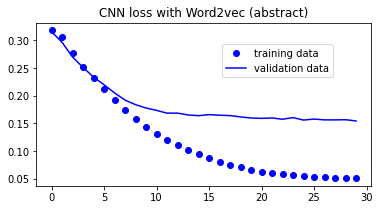

In [ ]:
history = pd.DataFrame(CNN_keywords_Word2vec.history)
plt.figure(figsize=(6,3));
plt.plot(history["loss"], 'bo', label='training data'); #puntos
plt.plot(history["val_loss"], 'b', label='validation data'); #linea
plt.title("LSTM loss with Word2vec (keywords)");
plt.legend(bbox_to_anchor=(0.9, 0.9))
plt.show();

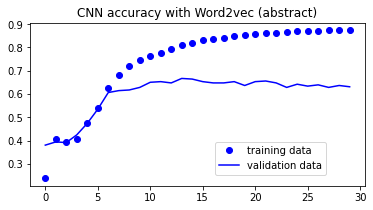

In [ ]:
history = pd.DataFrame(CNN_keywords_Word2vec.history)
plt.figure(figsize=(6,3));
plt.plot(history["accuracy"], 'bo', label='training data'); #puntos
plt.plot(history["val_accuracy"], 'b', label='validation data'); #linea
plt.title("CNN accuracy with Word2vec (keywords)");
plt.legend(bbox_to_anchor=(0.9, 0.3))
plt.show();